In [1]:
!git clone https://github.com/GouthamanAsokan/learnopencv.git

Cloning into 'learnopencv'...
remote: Enumerating objects: 5298, done.
remote: Total 5298 (delta 0), reused 0 (delta 0), pack-reused 5298
Receiving objects: 100% (5298/5298), 290.75 MiB | 14.16 MiB/s, done.
Resolving deltas: 100% (1402/1402), done.
Checking out files: 100% (2632/2632), done.


In [2]:
!wget http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/coco/pose_iter_440000.caffemodel

--2019-11-07 04:27:42--  http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/coco/pose_iter_440000.caffemodel
Resolving posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)... 128.2.176.37
Connecting to posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)|128.2.176.37|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209274056 (200M) [text/plain]
Saving to: ‘pose_iter_440000.caffemodel’

pose_iter_440000.ca 100%[===================>] 199.58M  14.1MB/s    in 18s     

2019-11-07 04:28:01 (11.1 MB/s) - ‘pose_iter_440000.caffemodel’ saved [209274056/209274056]



In [16]:
!wget https://cjiwr.com/wp-content/uploads/2015/09/Groups.jpg

--2019-11-07 04:40:03--  https://cjiwr.com/wp-content/uploads/2015/09/Groups.jpg
Resolving cjiwr.com (cjiwr.com)... 52.60.148.141
Connecting to cjiwr.com (cjiwr.com)|52.60.148.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141327 (138K) [image/jpeg]
Saving to: ‘Groups.jpg’

Groups.jpg          100%[===================>] 138.01K   243KB/s    in 0.6s    

2019-11-07 04:40:05 (243 KB/s) - ‘Groups.jpg’ saved [141327/141327]



In [0]:
#Importing the libraries
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from random import randint

In [0]:
protoFile = "/content/learnopencv/OpenPose-Multi-Person/pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "pose_iter_440000.caffemodel"
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

In [0]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    _, contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

In [0]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs

In [0]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [0]:
image1 = cv2.imread("Groups.jpg")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

In [18]:
#Load the network and pass the image through the network
t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
print("Time Taken = {}".format(time.time() - t))

Time Taken = 13.607316732406616


(-0.5, 1279.5, 719.5, -0.5)

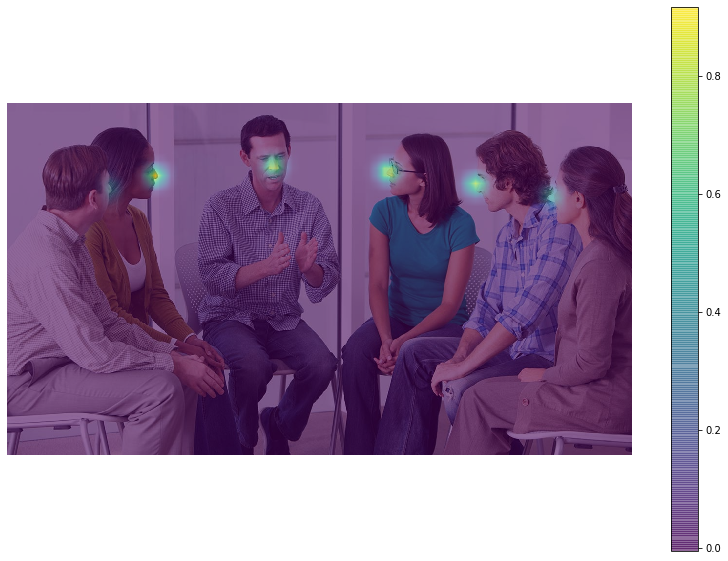

In [19]:
#Slice a probability map ( for e.g Nose ) from the output for a specific keypoint and plot the heatmap ( after resizing ) on the image itself
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

In [20]:
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)

Keypoints - Nose : [(1116, 195, 0.4651877), (210, 179, 0.3278833), (960, 164, 0.79191357), (304, 148, 0.9167731), (787, 147, 0.7265882), (539, 132, 0.74377096)]
Keypoints - Neck : [(1225, 305, 0.31538814), (101, 289, 0.4435061), (1069, 258, 0.73003936), (211, 243, 0.66207314), (850, 227, 0.7713266), (523, 210, 0.7346395)]
Keypoints - R-Sho : [(1240, 289, 0.14129668), (71, 304, 0.47878972), (1022, 259, 0.62081677), (164, 258, 0.5803247), (772, 225, 0.70456535), (443, 210, 0.5794271)]
Keypoints - R-Elb : [(179, 523, 0.556906), (975, 415, 0.59287566), (210, 414, 0.5796022), (757, 368, 0.81742626), (413, 352, 0.7006794)]
Keypoints - R-Wr : [(913, 539, 0.5026679), (336, 538, 0.72889435), (772, 478, 0.7576612), (523, 336, 0.77736384)]
Keypoints - L-Sho : [(1209, 335, 0.5425763), (132, 274, 0.29441956), (1131, 258, 0.63934046), (928, 242, 0.72364956), (272, 241, 0.70651627), (616, 210, 0.6734171)]
Keypoints - L-Elb : [(1195, 525, 0.57925016), (1052, 444, 0.61645067), (194, 416, 0.2863148), (9

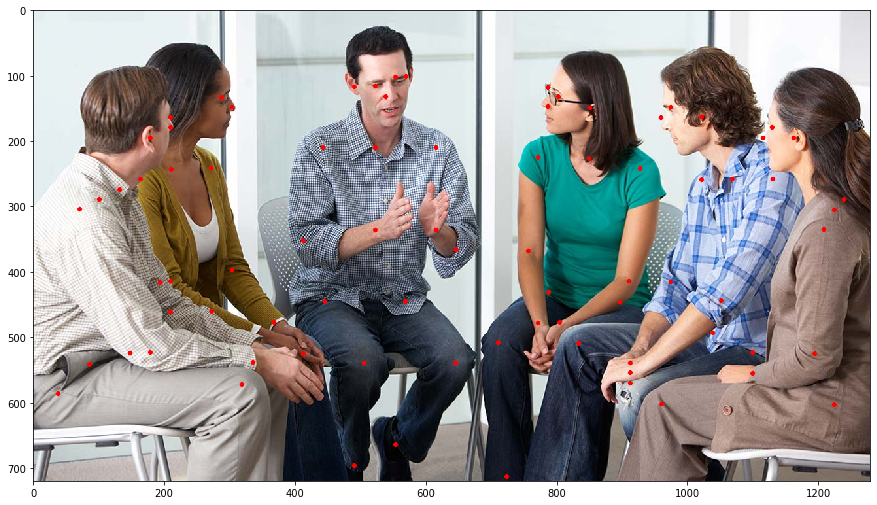

In [21]:
frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [22]:
valid_pairs, invalid_pairs = getValidPairs(output)

[array([[ 6.        , 12.        ,  0.23623482],
       [ 7.        , 13.        ,  0.33644293],
       [ 8.        , 14.        ,  0.67111183],
       [ 9.        , 15.        ,  0.51381904],
       [10.        , 16.        ,  0.89593938],
       [11.        , 17.        ,  0.86831388]]), array([[ 6.        , 27.        ,  0.3909696 ],
       [ 7.        , 31.        ,  0.42231021],
       [ 8.        , 29.        ,  0.71357688],
       [ 9.        , 31.        ,  0.74691099],
       [10.        , 30.        ,  0.69492568],
       [11.        , 32.        ,  0.8794021 ]]), array([[13.        , 18.        ,  0.67788569],
       [14.        , 19.        ,  0.65558684],
       [15.        , 20.        ,  0.74775153],
       [16.        , 21.        ,  0.75556637],
       [17.        , 22.        ,  0.79086271]]), array([[18.        , 24.        ,  0.82931731],
       [19.        , 23.        ,  0.56977985],
       [20.        , 24.        ,  0.55145184],
       [21.        , 25.        ,

In [0]:
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

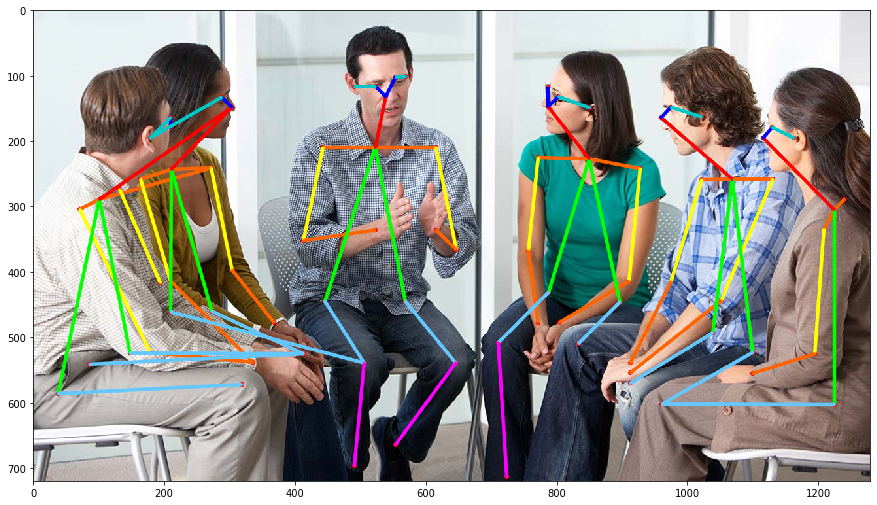

In [24]:
for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])